In [1]:
# Install yfinance library
%pip install -q yfinance --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import the necessary libraries
import requests
import pandas as pd
import yfinance as yf
import bs4 as bs
import pickle
import requests
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
warnings.filterwarnings("ignore")

In [4]:
# !wget --quiet -O "quarterly_statements.csv" "https://raw.githubusercontent.com/pilijevski/stock-prediction/main/lib/quarterly_statements.csv"

In [2]:
stocks = pd.read_csv("./lib/quarterly_statements.csv",index_col=0, parse_dates=True)

In [3]:
def get_snp_companies(subset='500'):
    WIKI_URL = f"http://en.wikipedia.org/wiki/List_of_S%26P_{subset}_companies"
    resp = requests.get(WIKI_URL)
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text[:-1]
        tickers.append(ticker)

    return tickers

In [4]:
stock_symbols = get_snp_companies('500') + get_snp_companies('400') + get_snp_companies('600')

In [5]:
stocks = stocks.loc['2022-01-01':]
stocks = stocks.loc[stocks.ticker.isin(stock_symbols)]
stocks['end_of_quarter'] = stocks.index

In [ ]:
meta_data = []
N = 1600
for ticker in tqdm(stock_symbols):
  try:
    stock = yf.Ticker(ticker)
    stock_info = stock.info
  except:
    continue
  stock_periods = stocks[stocks.ticker == ticker].index

  if len(stock_periods) < 8:
    print(f'The stock with ticker:{ticker} has less than 8 periods reported')
    continue
  for i in range(len(stock_periods) - 1, -1, -1):
    stock_features = []

    try:
      dividends = stock.dividends[stock_periods[i]- DateOffset(months=3):stock_periods[i]][-1]
    except:
      dividends = np.nan

    try:
      fte = stock_info['fullTimeEmployees']
    except:
      fte = np.nan

    try:
      auditrisk = stock_info['auditRisk']
    except:
      auditrisk = np.nan
    try:
      compensationrisk = stock_info['compensationRisk']
    except:
      compensationrisk = np.nan

    try:
      boardrisk = stock_info['boardRisk']
    except:
      boardrisk = np.nan

    try:
      shareholderrightsrisk = stock_info['shareHolderRightsRisk']
    except:
      shareholderrightsrisk = np.nan
    try:
      maxage = stock_info['maxAge']
    except:
      maxage = np.nan
    try:
      industry = stock_info['industry']
    except:
      industry =  np.nan

    try:
      sector = stock_info['sectorKey']
    except:
      sector = np.nan
    stock_features += [stock_periods[i], ticker, industry, sector, fte, auditrisk, compensationrisk,
                    boardrisk, shareholderrightsrisk, maxage, dividends]
    hist = stock.history(start=stock_periods[i] - DateOffset(months=3), end=stock_periods[i])
    try:
      hist['week_number'] = hist.index.week
    except:
      continue
    weekly_mean_close = hist.groupby('week_number')['Close'].mean()
    stock_features += list(weekly_mean_close.values[:10])
    stock_feature_columns = ['end_of_quarter','ticker', 'industry', 'sector', 'fte', 'auditrisk',
                            'compensationrisk', 'boardrisk', 'shareholderrightsrisk',
                            'maxage', 'dividends'] + [f'weekly_price_{w}' for w in range(len(list(weekly_mean_close.values[:10])))] + ['increase']

    try:
      hist = stock.history(start=stock_periods[i], end=stock_periods[i] + DateOffset(months=3))
      next_quarter_increase = (hist['Close'][-1] - hist['Close'][0]) / hist['Close'][0]
      stock_features += [next_quarter_increase]
      meta_data.append(stock_features)
    except:
      continue
  if N < 0:
    break
  N -= 1

In [ ]:
meta_df = pd.DataFrame(meta_data, columns=stock_feature_columns)
# meta_df.to_csv('/content/drive/MyDrive/Colab Notebooks/stocks/meta_df.csv', index=False)

In [ ]:
meta_df = pd.read_csv('meta_df.csv')
meta_df.end_of_quarter = pd.to_datetime(meta_df.end_of_quarter)

In [ ]:
df = pd.merge(stocks, meta_df, how='left', on=['ticker', 'end_of_quarter'])
df.head(5)

,Cash & Equivalents,Short-Term Investments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,...,weekly_price_1,weekly_price_2,weekly_price_3,weekly_price_4,weekly_price_5,weekly_price_6,weekly_price_7,weekly_price_8,weekly_price_9,increase
0,"13,715","15,432","29,147",13.78%,"4,884","3,209","4,887","42,127","2,005","3,364",...,50.278000,50.727500,51.822000,51.161896,51.925947,52.394304,50.503018,47.755897,47.764330,-0.046089
1,"9,602","17,335","26,937",14.79%,"4,833","3,342","4,547","39,659","2,004","3,324",...,51.831433,52.454056,53.190958,54.739635,56.107043,56.124774,55.547469,54.057901,52.613651,0.018920
2,"10,123","19,375","29,498",27.30%,"5,854","3,644","4,352","43,348","2,085","3,483",...,45.484898,46.732506,47.915582,48.789690,48.719293,50.107695,49.828548,49.843703,50.499490,-0.002068
3,"8,044","18,646","26,690",11.62%,"5,104","3,474","4,682","39,950","2,047","3,393",...,45.875569,47.701974,47.719929,47.222565,47.515646,47.907711,48.777243,49.650657,50.556973,0.108682
4,"9,009","16,609","25,618",2.02%,"5,237","3,140","4,520","38,515","1,964","3,554",...,47.451596,45.664979,46.609238,43.940697,43.099239,43.039547,43.981135,46.446299,47.320010,-0.027173
5,"7,292","16,175","23,467",-14.40%,"5,439","2,664","4,571","36,141","1,972","3,618",...,43.173816,43.587811,45.423129,44.900388,43.030732,43.076040,42.174124,39.926720,38.730521,0.076328
6,"7,079","16,093","23,172",-19.81%,"6,622","2,568","4,355","36,717","1,997","4,009",...,46.326377,43.983680,41.924603,42.854877,42.272511,40.965973,41.299698,40.642646,40.841512,0.017313
7,"6,952","16,960","23,912",-15.29%,"5,783","2,231","4,055","35,981","2,046","3,959",...,51.750259,51.583123,51.997675,52.416924,51.701433,52.178428,51.853542,52.259177,51.749174,-0.081862
8,"6,731","18,379","25,110",-29.50%,"6,003","2,059","3,627","36,799","2,140","4,024",...,58.060118,54.786410,52.313640,52.246143,53.312164,53.355103,51.883960,51.366353,51.902633,-0.084306
9,613.15,NaN,613.15,25.33%,"3,479",NaN,NaN,NaN,53.69,NaN,...,202.572000,206.686002,196.100003,197.316003,202.683997,206.498001,209.887501,210.501996,211.344003,0.207550


In [ ]:
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/stocks/stocks_processed.csv', index=False)

In [6]:
df = pd.read_csv('stocks_processed.csv')

In [7]:
# We keep only ratios for now, we don't know how to normalize other values e.g., Cash Flow properly
features = ['ticker', 'Net Cash / Debt','Net Cash / Debt Growth','Net Cash Per Share', 'Book Value Per Share',
         'Share Issuance / Repurchase', 'Debt Issued / Paid', 'Cash Growth', 'Debt Growth', 'Free Cash Flow Growth',
         'Free Cash Flow Margin', 'Free Cash Flow Per Share', 'Revenue Growth (YoY)', 'Interest Expense / Income',
         'Other Expense / Income', 'Net Income Growth', 'EPS (Basic)', 'EPS (Diluted)', 'EPS Growth', 'Free Cash Flow Per Share.1',
         'Dividend Per Share', 'Dividend Growth', 'Gross Margin', 'Operating Margin', 'Profit Margin', 'EBIT Margin',
         'Market Cap Growth', 'PE Ratio', 'PS Ratio', 'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'Debt / Equity Ratio',
         'Quick Ratio','Current Ratio','Interest Coverage', 'Return on Capital (ROIC)','Dividend Yield','Payout Ratio',
         'Buyback Yield / Dilution', 'Total Shareholder Return', 'Return on Equity (ROE)', 'Return on Assets (ROA)', 'Earnings Yield',
         'FCF Yield','industry', 'sector', 'fte', 'auditrisk', 'compensationrisk', 'boardrisk','shareholderrightsrisk','end_of_quarter','increase']

numerical_features = ['Net Cash / Debt','Net Cash / Debt Growth','Net Cash Per Share', 'Book Value Per Share',
         'Share Issuance / Repurchase', 'Debt Issued / Paid', 'Cash Growth', 'Debt Growth', 'Free Cash Flow Growth',
         'Free Cash Flow Margin', 'Free Cash Flow Per Share', 'Revenue Growth (YoY)', 'Interest Expense / Income',
         'Other Expense / Income', 'Net Income Growth', 'EPS (Basic)', 'EPS (Diluted)', 'EPS Growth', 'Free Cash Flow Per Share.1',
         'Dividend Per Share', 'Dividend Growth', 'Gross Margin', 'Operating Margin', 'Profit Margin', 'EBIT Margin',
         'Market Cap Growth', 'PE Ratio', 'PS Ratio', 'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'Debt / Equity Ratio',
         'Quick Ratio','Current Ratio','Interest Coverage', 'Return on Capital (ROIC)','Dividend Yield','Payout Ratio',
         'Buyback Yield / Dilution', 'Total Shareholder Return', 'Return on Equity (ROE)', 'Return on Assets (ROA)', 'Earnings Yield',
         'FCF Yield','fte', 'auditrisk', 'compensationrisk', 'boardrisk','shareholderrightsrisk','increase']

df = df[features]

In [8]:
# df = df.loc[df.end_of_quarter > '2023-01-01']

In [9]:
# remove commas from thousands, and replace values that have only '-' with nan
tmp = df['end_of_quarter'].copy()
for col in list(df.columns):
  try:
    df.loc[:, col] = df.loc[:, col].str.replace(',', '').replace(r'^-$', np.nan, regex=True)
  except:
    pass
# all percentage columns, remove the percent sign
percentage_columns = [col for col in df.columns if any(df[col].astype(str).str.contains('%'))]
for col in percentage_columns:
  df.loc[:, col] = df.loc[:, col].str.replace('%', '')
df['end_of_quarter'] = tmp

In [10]:
# normalizing the values by dividing by total_revenue as suggested by financial books, in order for us to be able to compare companies on the more or less same scale
df[numerical_features] = df[numerical_features].astype('float')

In [11]:
# Should we scale ratios? Ratios are already scaled
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# # Fit and transform the DataFrame
# df[cols] = scaler.fit_transform(df[cols])

In [12]:
# not needed since we are not dividing with 0 nowhere
# df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
# one hot encoding of industry and sector
one_hot_encoded_industry = pd.get_dummies(df['industry'], prefix='industry')
one_hot_encoded_sector = pd.get_dummies(df['sector'], prefix='sector')
df = pd.concat([df, one_hot_encoded_industry, one_hot_encoded_sector], axis=1)
df.drop(['industry', 'sector'], axis=1, inplace=True)

In [14]:
df.increase.max(), df.increase.min()

(2.4037833028603024, -0.6380806484245339)

In [15]:
# where target variable does not exists, remove those rows
df.dropna(axis=0, inplace=True, subset=['increase'])

In [16]:
df_test = df.groupby('ticker', as_index=False).first()
df_train = df.loc[~df.end_of_quarter.isin(df_test.end_of_quarter)]
df_train.shape, df_test.shape

((10246, 220), (1465, 220))

In [17]:
y_train = df_train[['increase', 'ticker']]
y_test = df_test[['increase', 'ticker']]
df_test = df_test.drop(['ticker', 'end_of_quarter', 'increase'], axis=1)
df_train = df_train.drop(['ticker', 'end_of_quarter', 'increase'], axis=1)

In [18]:
y_train['increase_real_values'] = y_train.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
y_train.increase[y_train.increase_real_values >= class_thresholds[3]] = 4
y_train.increase[(y_train.increase_real_values >= class_thresholds[2]) & (y_train.increase_real_values < class_thresholds[3])] = 3
y_train.increase[(y_train.increase_real_values >= class_thresholds[1]) & (y_train.increase_real_values < class_thresholds[2])] = 2
y_train.increase[(y_train.increase_real_values > class_thresholds[0]) & (y_train.increase_real_values < class_thresholds[1])] = 1
y_train.increase[y_train.increase_real_values <= class_thresholds[0]] = 0

In [19]:
class_counts = dict(zip(*np.unique(y_train.increase.values, return_counts=True)))
class_weights = {class_label: len(y_train.increase.values) / (len(np.unique(y_train.increase.values)) * count) for class_label, count in class_counts.items()}
class_counts, class_weights

({0.0: 2610, 1.0: 2519, 2.0: 2242, 3.0: 1589, 4.0: 1286},
 {0.0: 0.7851340996168582,
  1.0: 0.8134974196109567,
  2.0: 0.9140053523639607,
  3.0: 1.2896161107614852,
  4.0: 1.5934681181959565})

In [20]:
df_train.fillna(np.iinfo('int').max, inplace=True)
df_test.fillna(np.iinfo('int').max, inplace=True)

In [21]:
# Assuming you have your features (x) and labels (y) ready, split the data.
X_train, X_test, Y_train, Y_test = train_test_split(df_train, y_train, test_size=0.1, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier

# We fit a classifier to predict the increase in percentage into the next Q
# Initialize
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=42) # , class_weight=class_weights)

# Fit the model to the training data
rf_classifier.fit(X_train, Y_train.increase)

RandomForestClassifier(n_estimators=300, random_state=42)

In [23]:
# Predict on the test set
rf_classifier.predict(X_test)
ticker = Y_test.ticker
p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
# Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
K = 10
p.sort_values(by='preds')[::-1].iloc[:K]

,ticker,preds,true,increase
3943,MLI,4.0,2.0,0.032526
7666,ARCB,4.0,2.0,0.028846
10503,BMI,4.0,1.0,-0.025007
1265,BLDR,4.0,4.0,0.319816
8254,PBI,4.0,0.0,-0.146893
10163,CPRX,4.0,0.0,-0.161641
4048,PR,4.0,3.0,0.122074
2566,SNV,4.0,4.0,0.412758
416,MDC,4.0,0.0,-0.118452
6514,ANF,4.0,2.0,0.078386


In [24]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.true.value_counts().values})

,value,pred_counts,true_counts
0,0.0,398,259
1,1.0,334,259
2,2.0,190,234
3,3.0,69,142
4,4.0,34,131


In [25]:
from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(p.true, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.true, p.preds)}')

Accuracy: 0.3073170731707317
Confusion matrix: 
 [[141  67  37   7   7]
 [ 85 100  48  19   7]
 [ 72  83  51  19   9]
 [ 51  46  27  15   3]
 [ 49  38  27   9   8]]


In [26]:
# predicting on the SNP 500 stocks
p = pd.DataFrame({"ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]), "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
# selecting the top K stocks we want to put money in
K = 10
p.sort_values(by='preds')[::-1][:K]

,ticker,preds,increase
1347,URI,4.0,0.267942
1368,VLO,4.0,0.308587
71,AMD,4.0,0.289363
1308,TT,4.0,0.262893
235,CCL,4.0,0.027224
88,ANET,4.0,0.315426
585,GS,4.0,0.065439
99,APH,4.0,0.183938
603,HBAN,4.0,0.058320
731,KEY,4.0,0.051335


In [27]:
f'We have gain (positive) or loss (negative) of {p.sort_values(by="preds")[::-1][:K].increase.mean() * 100}% on the invested {K} stocks'

'We have gain (positive) or loss (negative) of 18.30468865569165% on the invested 10 stocks'

In [28]:
p['increase_real_values'] = p.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
p.increase[p.increase_real_values >= class_thresholds[3]] = 4
p.increase[(p.increase_real_values >= class_thresholds[2]) & (p.increase_real_values < class_thresholds[3])] = 3
p.increase[(p.increase_real_values >= class_thresholds[1]) & (p.increase_real_values < class_thresholds[2])] = 2
p.increase[(p.increase_real_values > class_thresholds[0]) & (p.increase_real_values < class_thresholds[1])] = 1
p.increase[p.increase_real_values <= class_thresholds[0]] = 0

In [29]:
# Compute accuracy on test
accuracy = accuracy_score(p.increase, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.increase, p.preds)}')

Accuracy: 0.27655310621242485
Confusion matrix: 
 [[19 15  2  3  1]
 [24 58 23  1  0]
 [31 76 40 12  5]
 [24 50 33 14  2]
 [18 11 19 11  7]]


In [30]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.increase.value_counts().values})

,value,pred_counts,true_counts
0,1.0,210,164
1,2.0,117,123
2,0.0,116,106
3,3.0,41,66
4,4.0,15,40


<Figure size 1600x1600 with 0 Axes>

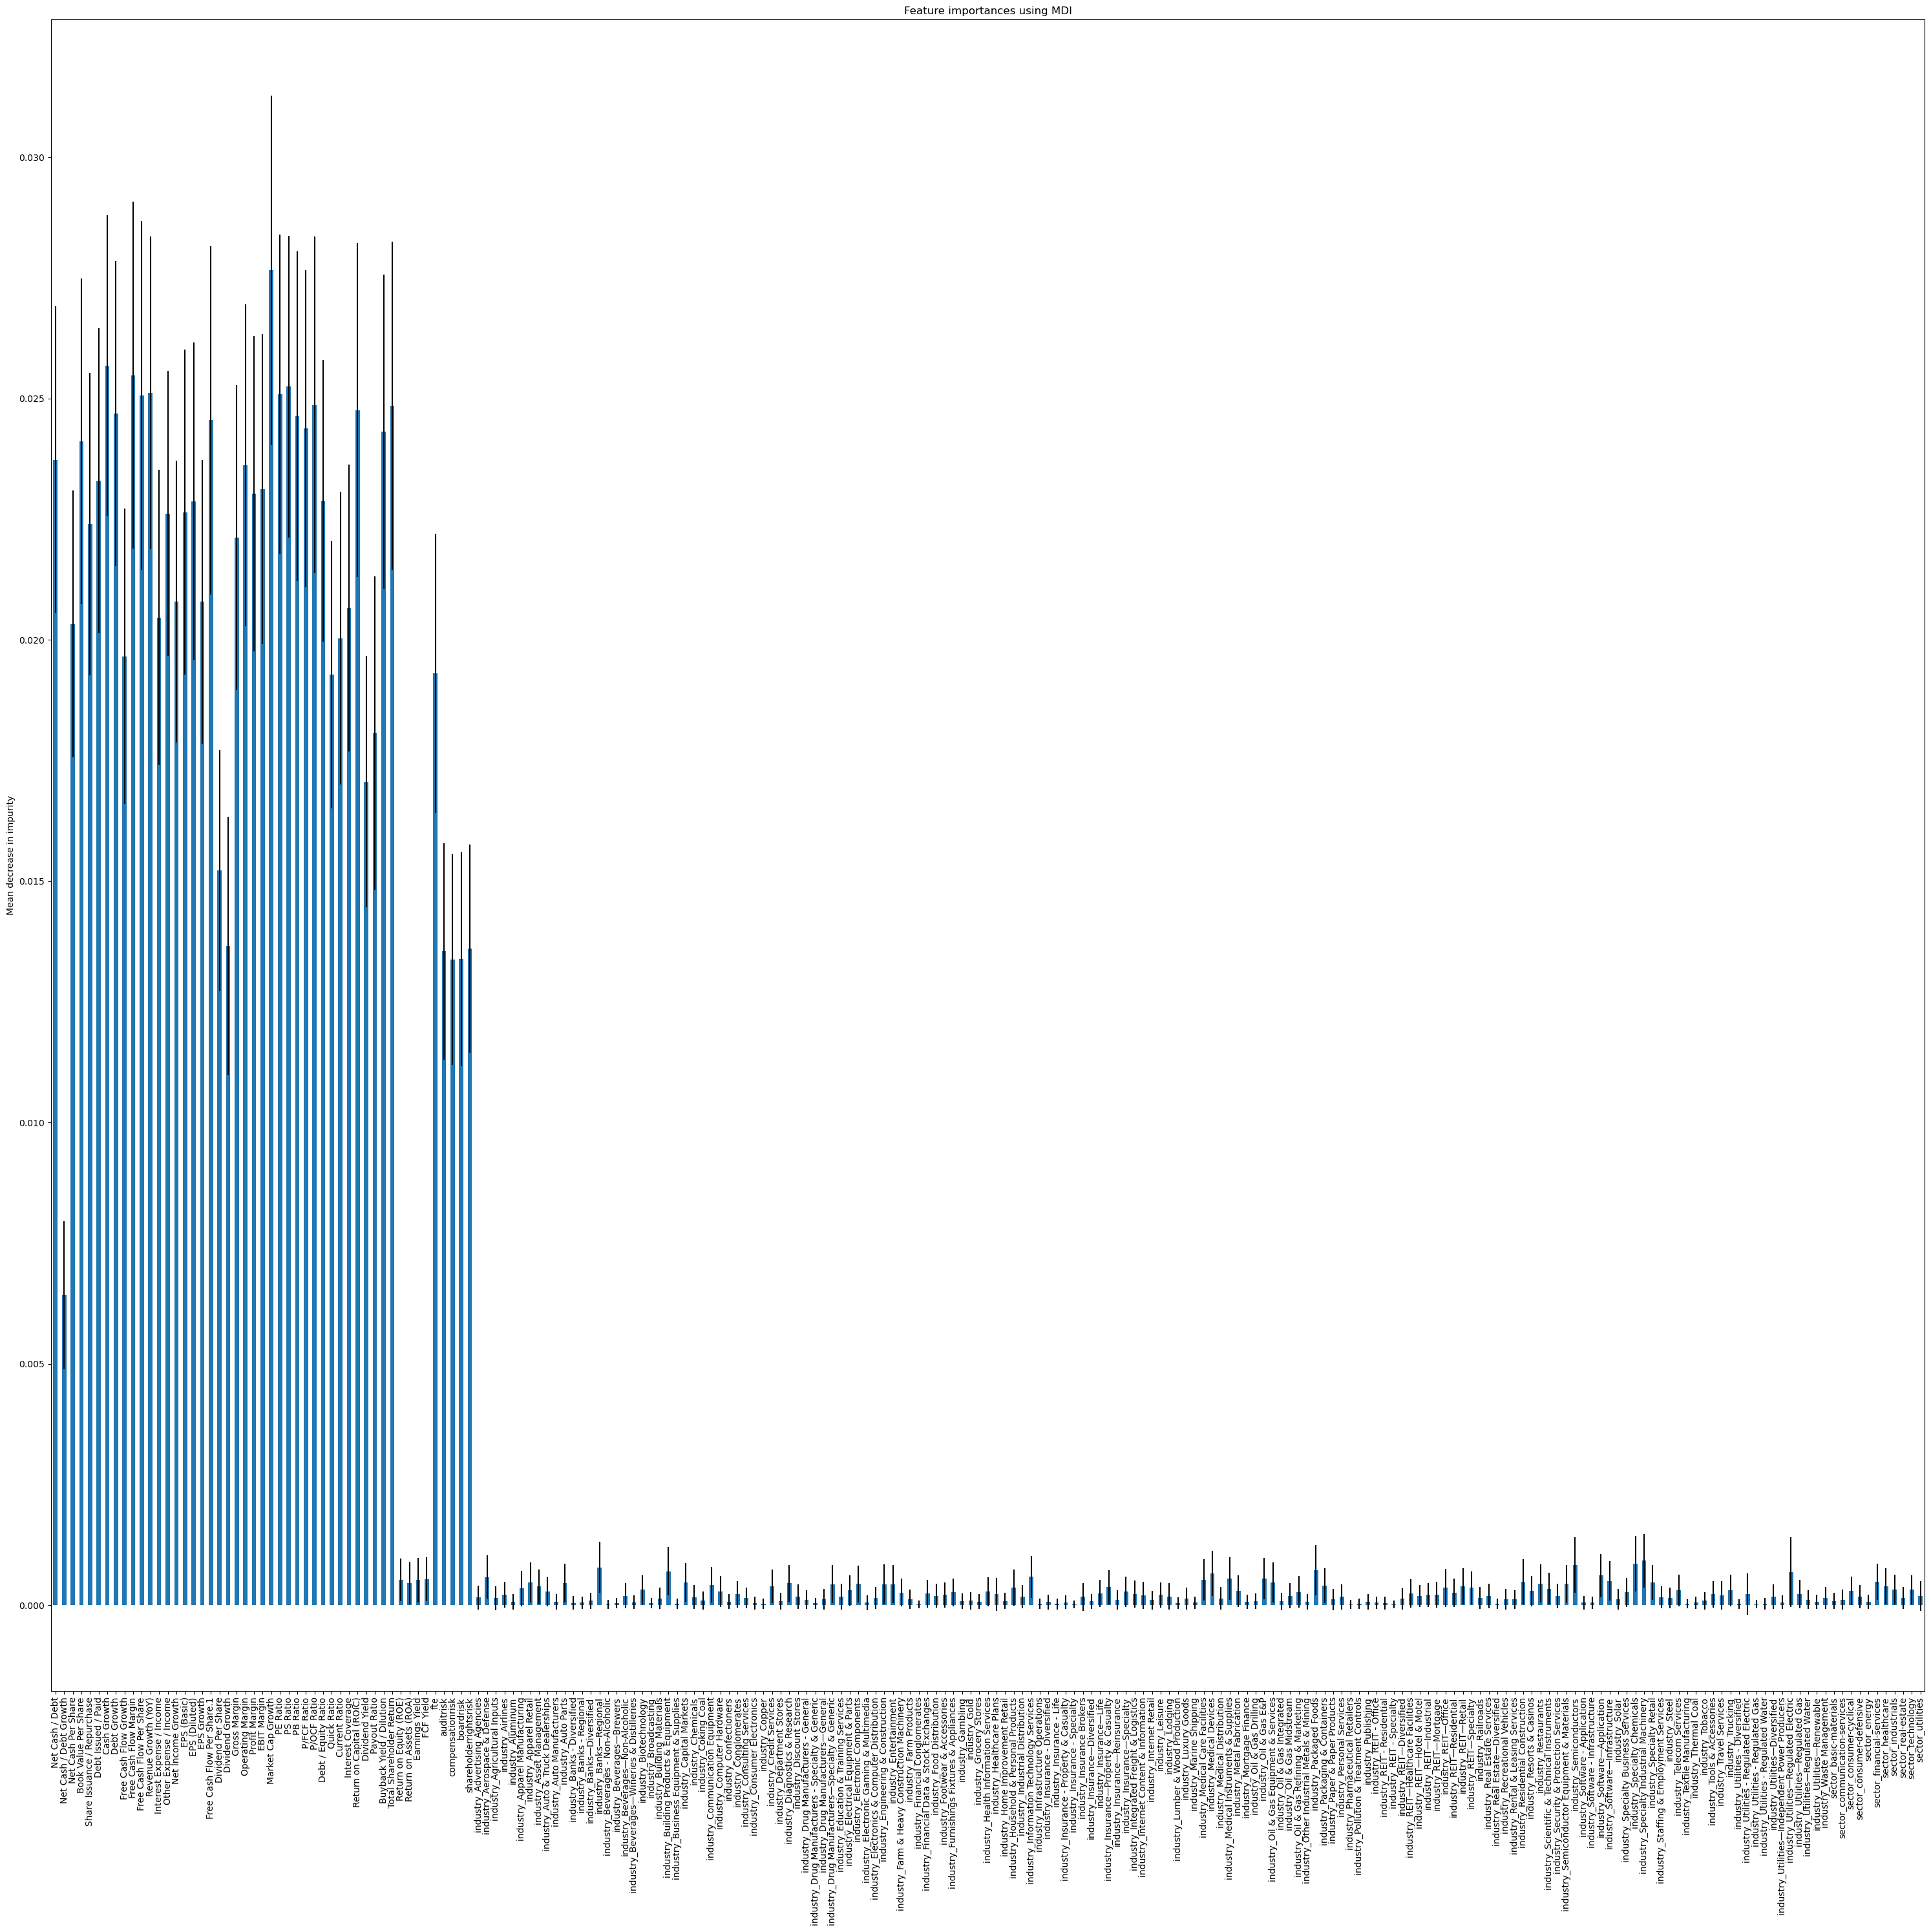

In [31]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=list(df_train.columns))
plt.figure(figsize=(16,16))
fig, ax = plt.subplots(figsize=(30,30))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('feature_importances_plot.png')